In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from util_out import *
from util_f1 import *
from scipy.io import loadmat, savemat
from IPython.display import Audio, display, Image, YouTubeVideo
import os
import pickle
from collections import Counter
import torch
import torchaudio

In [2]:
GAS_FEATURE_DIR = '/jet/home/billyli/data_folder/data/googleAudioSet/pylon5/ir3l68p/kaixinm/cmu-thesis/data/audioset'
DCASE_FEATURE_DIR = '/jet/home/billyli/data_folder/data/dcase'

In [3]:
with open(os.path.join(GAS_FEATURE_DIR, 'normalizer.pkl'), 'rb') as f:
    mu, sigma = pickle.load(f, encoding='bytes')

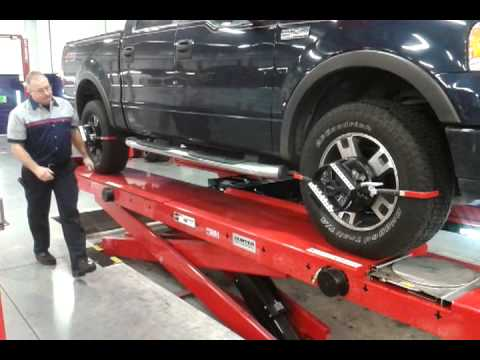

In [4]:
filename = '--BfvyPmVMo.wav'
YouTubeVideo('--BfvyPmVMo')

Notice the first way of loading wav is **WRONG** since it's only 16kHz. Loading it with the default 22050Hz will result in time domain shift!

In [5]:
y, sr = librosa.load(filename) 
# trim silent edges
hammer_sound_wrong, _ = librosa.effects.trim(y)
print(y.shape, sr)
Audio(data=hammer_sound_wrong, rate=sr)


(220500,) 22050


In [74]:
y, sr = librosa.load(filename, sr =16000)
# trim silent edges
hammer_sound, _ = librosa.effects.trim(y)
print(y.shape, sr)
Audio(data=hammer_sound, rate=sr)

(160000,) 16000


AST https://github.com/YuanGongND/ast/blob/09654923daf52c0d1b488f1af610a5cd05bf11f2/src/run.py way of loading waveform

In [36]:
ori_waveform, sr = torchaudio.load(filename)
waveform = ori_waveform - ori_waveform.mean()
noise = torch.randn_like(waveform)*0.1
n_waveform = noise+waveform
print(waveform.shape, sr)

torch.Size([1, 160000]) 16000


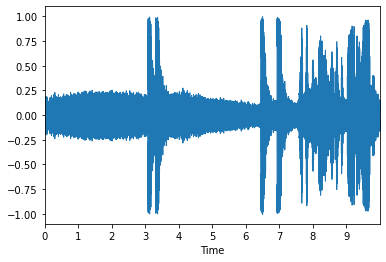

In [37]:
librosa.display.waveplot(waveform.squeeze().numpy(), sr=sr);

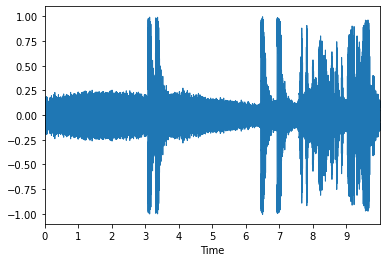

In [38]:
librosa.display.waveplot(ori_waveform.squeeze().numpy(), sr=sr);

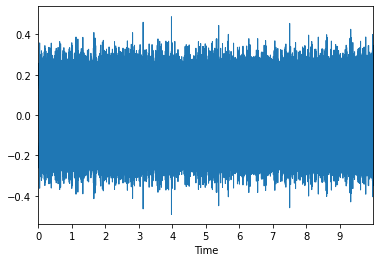

In [39]:
librosa.display.waveplot(noise.squeeze().numpy(), sr=sr);

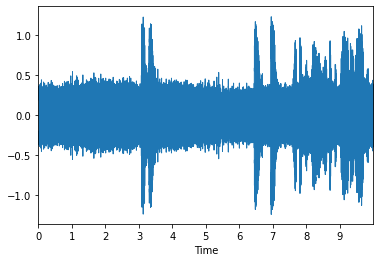

In [40]:
librosa.display.waveplot(n_waveform.squeeze().numpy(), sr=sr);

# Masking the Recoding

In [8]:
record=numpy.ma.array(y,mask=False)
# record.mask[22050:44100]=True
count = 0
for i in range(220500):
    #11025 0.5s, 5512 0.25s, 2756 0.125s
    if i % 2756 == 0:
        count +=1
    if count % 2 == 1:
        record.mask[i] = True
# print('shape:', record.shape)
# print('mask: ', Counter(record.mask))
#     mask_record = record[~record.mask]
#     print(mask_record.shape)
#     print(record.compressed().shape)
mask_record = record.filled(fill_value=0)
# mask_record = record.compressed().reshape(110250,1)
# print('masked shape: ', mask_record.shape)

# fill_matrix = numpy.full((110250,1), 0)
# print('shape', fill_matrix.shape)
# mask_record = numpy.vstack((mask_record, fill_matrix)).reshape(220500)
print(mask_record.shape)

(220500,)


In [9]:
Audio(data=mask_record, rate=sr)

(220500,)


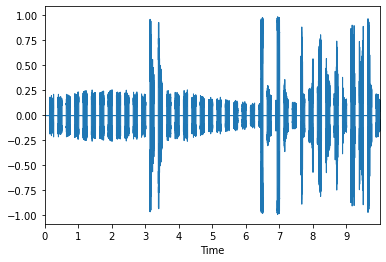

In [10]:
librosa.display.waveplot(mask_record, sr=sr);
print(mask_record.shape)

In [51]:
record=numpy.ma.array(y,mask=False)

# record.mask[22050:44100]=True
count = 0
for i in range(220500):
    if i % 11025 == 0:
        count +=1
    if count % 2 == 1:
        record.mask[i] = True
# print('shape:', record.shape)
# print('mask: ', Counter(record.mask))
#     mask_record = record[~record.mask]
#     print(mask_record.shape)
#     print(record.compressed().shape)
mask_record_concat= record.filled(fill_value=0)
mask_record_concat= record.compressed().reshape(110250,1)
print('masked shape: ', mask_record.shape)

fill_matrix = numpy.full((110250,1), 0)
print('shape', fill_matrix.shape)
mask_record_concat = numpy.vstack((mask_record_concat, fill_matrix)).reshape(220500)
print(mask_record_concat[:,].shape)

masked shape:  (220500,)
shape (110250, 1)
(220500,)


(220500,)


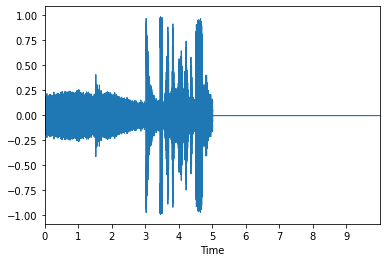

In [52]:
librosa.display.waveplot(mask_record_concat, sr=sr);
print(mask_record_concat.shape)

In [32]:
Audio(data=mask_record_concat, rate=sr)

### STFT of the signal

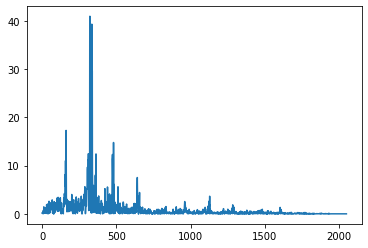

In [76]:
n_fft = 4096
D = np.abs(librosa.stft(hammer_sound[:n_fft], n_fft=n_fft, hop_length=n_fft+1))
plt.plot(D);

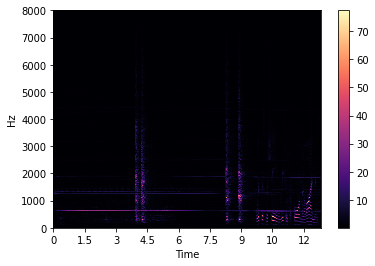

In [79]:
hop_length = 400
D = np.abs(librosa.stft(hammer_sound, n_fft=n_fft, hop_length=hop_length, win_length=1024, window='hann', center = True, pad_mode = 'constant'))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='linear');
plt.colorbar();

### 3 ways to extract features, extract method is used by us, whereas AST pipeline use the 3rd one, 2nd one is deprecated. 

In [52]:
def extract(wav):
    # Takes a waveform (length 160,000, sampling rate 16,000) and extracts filterbank features (size 400 * 64)
    # If the input is multiple waveforms (i.e. size n * 160,000), extract feature for each waveform (i.e. output size n * 400 * 64)
    spec = librosa.core.stft(wav, n_fft = 4096,
                             hop_length = 400, win_length = 1024,
                             window = 'hann', center = True, pad_mode = 'constant')
    mel = librosa.feature.melspectrogram(S = numpy.abs(spec), sr = 16000, n_mels = 64, fmax = 8000)
    logmel = librosa.core.power_to_db(mel[:, :400])
    return logmel.T.astype('float32')

In [37]:
def extract2(wav):
    # Takes a waveform (length 160,000, sampling rate 16,000) and extracts filterbank features (size 400 * 64)
    # If the input is multiple waveforms (i.e. size n * 160,000), extract feature for each waveform (i.e. output size n * 400 * 64)
    spec = librosa.core.stft(wav, n_fft = 4096,
                             hop_length = 480, win_length = 2048,
                             window = 'hann', center = True, pad_mode = 'constant')
    mel = librosa.feature.melspectrogram(S = numpy.abs(spec), sr = 16000, n_mels = 64, fmax = 8000)
    logmel = librosa.core.power_to_db(mel[:, :400])
    return logmel.T.astype('float32')

In [26]:
def extract3(wav, sr):
    fbank = torchaudio.compliance.kaldi.fbank(wav, htk_compat=True, sample_frequency=sr, use_energy=False,
                                                  window_type='hanning', num_mel_bins=128, dither=0.0, frame_shift=10)

    target_length = 1024
    print('fbank shape: ', fbank.shape)
    
    n_frames = fbank.shape[0]
    p = target_length - n_frames
    if p > 0:
            m = torch.nn.ZeroPad2d((0, 0, 0, p))
            fbank = m(fbank)
    elif p < 0:
            fbank = fbank[0:target_length, :]
    return fbank

In [80]:
logmel = extract(hammer_sound)

In [38]:
logmel = extract2(hammer_sound)

In [41]:
filterbank = extract3(n_waveform, sr)

fbank shape:  torch.Size([998, 128])


In [100]:
logmel_norm = (logmel -mu)/sigma

In [97]:
upsample = torch.nn.Upsample((1024,128), mode='bilinear', align_corners=True)

In [106]:
logmel_norm_tensor = torch.from_numpy(logmel_norm)
print(logmel_norm_tensor.view(1, 1, 400, 64).shape)

torch.Size([1, 1, 400, 64])


In [107]:
logmel_upsample = upsample(logmel_norm_tensor.view(1, 1, 400, 64))

In [42]:
filter_norm = (filterbank+4.2677393)/4.5689974 #'audioset':[-4.2677393, 4.5689974]

In [119]:
print(logmel_norm)
print(np.min(logmel_norm), np.max(logmel_norm), np.mean(logmel_norm), np.std(logmel_norm))

[[-0.27796373 -0.40638483 -0.51413109 ... -0.05149274 -0.15646126
  -0.09784603]
 [-0.2103393  -0.29243671 -0.10422522 ...  0.13435178  0.01097979
  -0.06657247]
 [-0.17008328 -0.25884248 -0.17213303 ...  0.17775229 -0.07895804
  -0.15532747]
 ...
 [-0.28396884  0.218033    0.18446829 ...  0.15772414  0.00498628
  -0.35354341]
 [-0.29123717  0.03484562  0.14914982 ...  0.13057377 -0.01570792
  -0.26340808]
 [-0.44113124  0.07314658  0.0990892  ...  0.2286465   0.09787659
   0.05869525]]
-1.0035631433107648 1.8376575439572003 0.37248764759921427 0.388339960105517


In [32]:
plt.figure(figsize = (20,10))
plt.imshow(logmel_norm.T, origin='lower')

NameError: name 'logmel_norm' is not defined

<Figure size 1440x720 with 0 Axes>

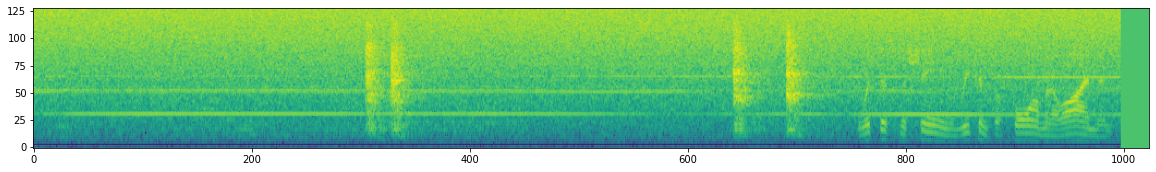

In [43]:
plt.figure(figsize = (20,10))
plt.imshow(filter_norm.T, origin='lower')

In [116]:
print(filter_norm)
print(torch.min(filter_norm), torch.max(filter_norm), torch.mean(filter_norm), torch.std(filter_norm))

tensor([[-1.4087, -2.3869, -1.6332,  ..., -0.2877, -0.8363, -2.1948],
        [-1.4708, -1.9906, -1.2370,  ..., -0.4711, -0.9858, -2.1814],
        [-1.1229, -1.7968, -1.0431,  ..., -0.3306, -0.8338, -2.2764],
        ...,
        [ 0.9341,  0.9341,  0.9341,  ...,  0.9341,  0.9341,  0.9341],
        [ 0.9341,  0.9341,  0.9341,  ...,  0.9341,  0.9341,  0.9341],
        [ 0.9341,  0.9341,  0.9341,  ...,  0.9341,  0.9341,  0.9341]])
tensor(-2.5552) tensor(2.3256) tensor(0.2687) tensor(0.7120)


In [117]:
print(logmel_upsample)
print(torch.min(logmel_upsample), torch.max(logmel_upsample), torch.mean(logmel_upsample), torch.std(logmel_upsample))

tensor([[[[-0.2780, -0.3417, -0.4054,  ..., -0.1560, -0.1269, -0.0978],
          [-0.2516, -0.3063, -0.3611,  ..., -0.0911, -0.0884, -0.0856],
          [-0.2252, -0.2710, -0.3168,  ..., -0.0262, -0.0498, -0.0735],
          ...,
          [-0.3242, -0.1419,  0.0404,  ...,  0.0077, -0.0924, -0.1926],
          [-0.3827, -0.1640,  0.0547,  ...,  0.0526, -0.0072, -0.0669],
          [-0.4411, -0.1860,  0.0691,  ...,  0.0976,  0.0781,  0.0587]]]],
       dtype=torch.float64)
tensor(-0.9950, dtype=torch.float64) tensor(1.7954, dtype=torch.float64) tensor(0.3771, dtype=torch.float64) tensor(0.3687, dtype=torch.float64)


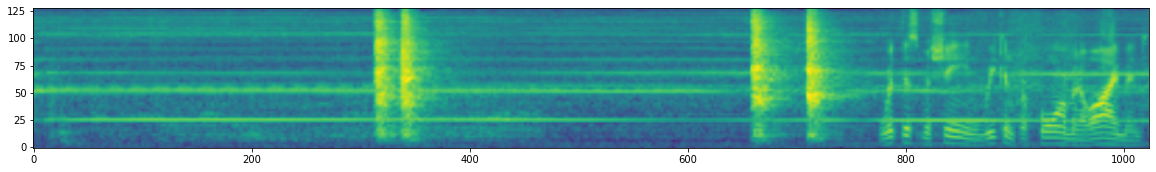

In [111]:
plt.figure(figsize = (20,10))
plt.imshow(logmel_upsample.squeeze().T, origin='lower')

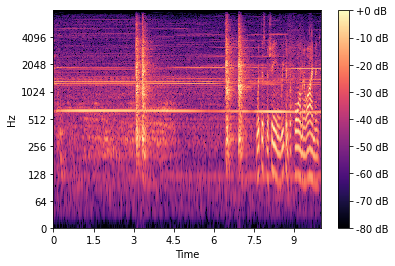

In [92]:
DB = librosa.amplitude_to_db(D, ref=np.max)
librosa.display.specshow(DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');

In [88]:
n_mels = 64
sr = 16000
mel = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)

(64, 401)
(64, 400)


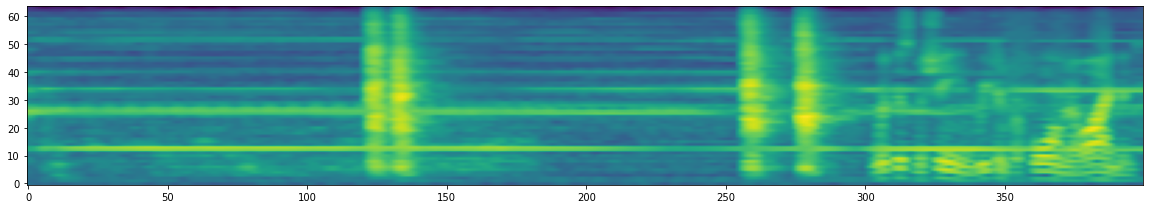

In [89]:
S = librosa.feature.melspectrogram(hammer_sound, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels,fmax = 8000)
print(S.shape)
S_DB = librosa.power_to_db(S[:,:400], ref=np.max)
print(S_DB.shape)
plt.figure(figsize=(20, 10));
plt.imshow(((S_DB.T - mu) / sigma).T, origin='lower')
# librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis='time');
# plt.colorbar(format='%+2.0f dB');

((10, 100, 527), (10, 100, 527))


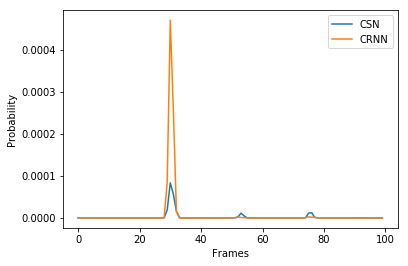

In [11]:
a = np.load('TALtransframe_516.npy')
b = np.load('TALframe_516.npy')
print (a.shape, b.shape)
line1 = plt.plot(a[0,:,516], label='CSN')
line2 = plt.plot(b[0,:,516], label='CRNN')
plt.xlabel('Frames')
plt.ylabel('Probability')
plt.legend(loc='upper right')
plt.show()

Text(0.5,0.98,'Eval set mAP vs checkpoints')

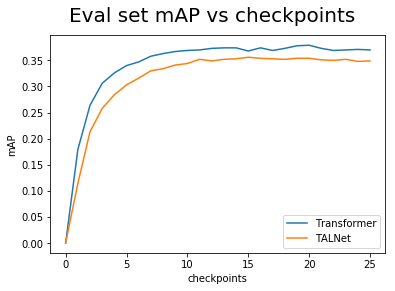

In [18]:
def parse_files(filename):
    MAP = [0.0]
    with open(filename, 'r') as f:
        for i, line in enumerate(f):
            if i < 5:
                continue
            MAP.append(float(line.split()[14]))
            if len(MAP) == 26:
                break
    return MAP
transformer = parse_files('../../workspace/audioset/TAL-trans-embed1024-10C5P-kernel3x3-bn-drop0.0-att-batch100-ckpt2500-adam-lr2e-04-pat3-fac0.8-seed15213-Trans2-weight-decay0.00000000-betas0.900-0.999dropout0.75/train.log')
#print (transformer)
TALnet = parse_files('../../workspace/audioset/embed1024-10C5P-kernel3x3-bn-drop0.0-lin-batch250-ckpt1000-adam-lr1e-03-pat3-fac0.8-seed15213/train.log')
#print (TALnet)
plt.plot(transformer, label='Transformer')
plt.plot(TALnet, label='TALNet')
plt.legend(loc='lower right')
plt.xlabel('checkpoints')
plt.ylabel('mAP')
plt.suptitle('Eval set mAP vs checkpoints', fontsize=20)


In [3]:
import timm

In [4]:
print(timm.__version__)

0.4.5


In [5]:
model = timm.create_model('vit_deit_base_distilled_patch16_384', pretrained=True)

In [13]:
original_num_patches = model.patch_embed.num_patches
print(original_num_patches)

576


In [9]:
original_hw = int(original_num_patches ** 0.5)

In [10]:
print(original_hw)

24


In [11]:
original_embedding_dim = model.pos_embed.shape[2]

In [12]:
print(original_embedding_dim)

768


In [9]:
model.blocks

ModuleList(
  (0): Block(
    (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (attn): Attention(
      (qkv): Linear(in_features=768, out_features=2304, bias=True)
      (attn_drop): Dropout(p=0.0, inplace=False)
      (proj): Linear(in_features=768, out_features=768, bias=True)
      (proj_drop): Dropout(p=0.0, inplace=False)
    )
    (drop_path): Identity()
    (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (mlp): Mlp(
      (fc1): Linear(in_features=768, out_features=3072, bias=True)
      (act): GELU()
      (fc2): Linear(in_features=3072, out_features=768, bias=True)
      (drop): Dropout(p=0.0, inplace=False)
    )
  )
  (1): Block(
    (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (attn): Attention(
      (qkv): Linear(in_features=768, out_features=2304, bias=True)
      (attn_drop): Dropout(p=0.0, inplace=False)
      (proj): Linear(in_features=768, out_features=768, bias=True)
      (proj_drop): Dropout(p=0.0, inplac

In [21]:
torch.sum(model.patch_embed.proj.weight, dim=1).unsqueeze(1).shape

torch.Size([768, 1, 16, 16])

In [23]:
model.patch_embed.proj.bias.shape

torch.Size([768])

In [24]:
new_proj = torch.nn.Conv2d(1, original_embedding_dim, kernel_size=(16, 16), stride=(10,10))

In [26]:
model.patch_embed.proj=new_proj 

In [27]:
print(model.patch_embed.proj)

Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))


In [29]:
print(model.patch_embed)

PatchEmbed(
  (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
)


In [30]:
model.norm

LayerNorm((768,), eps=1e-06, elementwise_affine=True)

In [8]:
rng = np.random.RandomState(15213)

In [11]:
print(rng)

RandomState(MT19937)


In [15]:
numpy.random.randint(40,100)

71